In [3]:
import os
print(os.getcwd())
os.chdir('/root/LIFT')
print(os.getcwd())

/root/LIFT/plot
/root/LIFT


In [4]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datasets import ImageNet_LT
from models import *
from trainer import load_clip_to_cpu
from utils.evaluator import PGD

from utils.config import _C as cfg

os.chdir('/root/LIFT')

cfg.defrost()
cfg.merge_from_file('./configs/data/imagenet_lt.yaml')
cfg.merge_from_file('./configs/model/clip_vit_b16.yaml')
cfg.adaptformer = True

if not torch.cuda.is_available():
    device = torch.device("cpu")
elif cfg.gpu is None:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(cfg.gpu)
    device = torch.device("cuda:{}".format(cfg.gpu))

cfg.model_dir = './output/imagenet_lt_clip_vit_b16_adaptformer_True'

/root/miniconda3/envs/LIFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if cfg.backbone.startswith("CLIP"):
    mean = [0.48145466, 0.4578275, 0.40821073]
    std = [0.26862954, 0.26130258, 0.27577711]
else:
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

transform_test = transforms.Compose([
    transforms.Resize(cfg.resolution * 8 // 7),
    transforms.CenterCrop(cfg.resolution),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = ImageNet_LT(root=cfg.root, train=True, transform=transform_test)
num_classes = train_dataset.num_classes
cls_num_list = train_dataset.cls_num_list
test_dataset = ImageNet_LT(root=cfg.root, train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

clip_model = load_clip_to_cpu(cfg.backbone, cfg.prec)
model = PeftModelFromCLIP(cfg, clip_model, num_classes)
model.to(device)
tuner = model.tuner
head = model.head

load_path = os.path.join(cfg.model_dir, "checkpoint.pth.tar")
checkpoint = torch.load(load_path, map_location=device)
tuner_dict = checkpoint["tuner"]
head_dict = checkpoint["head"]
tuner.load_state_dict(tuner_dict)
head.load_state_dict(head_dict)

Adapter bottle dimension set to 32


/tmp/ipykernel_10875/4131593557.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=device)


<All keys matched successfully>

In [6]:
def visualize_images(original_images, adversarial_images, labels, adv_labels, class_names):
    """
    Visualizes original and adversarial images side by side.
    """
    batch_size = original_images.size(0)
    for i in range(batch_size):
        original = original_images[i].permute(1, 2, 0).cpu().numpy()
        adversarial = adversarial_images[i].permute(1, 2, 0).cpu().numpy()
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow((original * std + mean).clip(0, 1))
        axes[0].set_title(f"Original: {class_names[labels[i].item()]}")
        axes[0].axis("off")

        axes[1].imshow((adversarial * std + mean).clip(0, 1))
        axes[1].set_title(f"Adversarial: {class_names[adv_labels[i].item()]}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()


  0%|          | 0/782 [00:00<?, ?it/s]

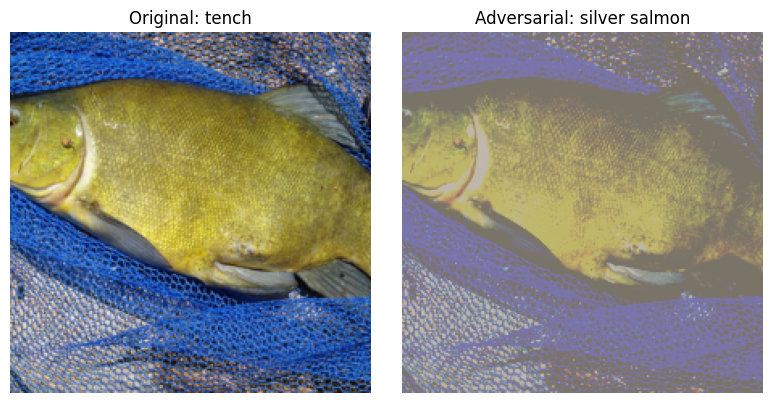

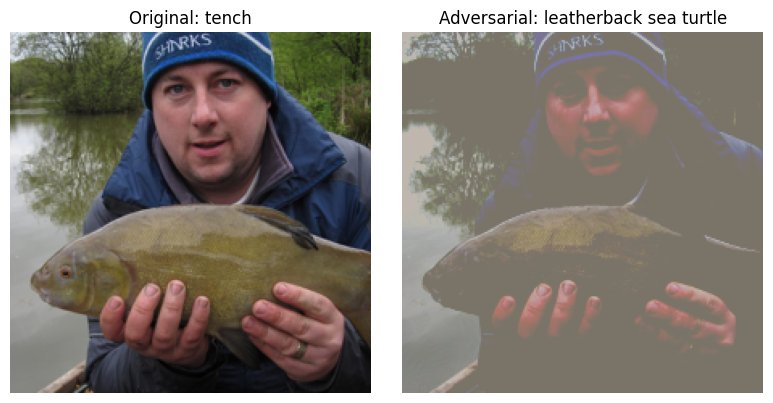

  0%|          | 1/782 [00:04<57:51,  4.44s/it]

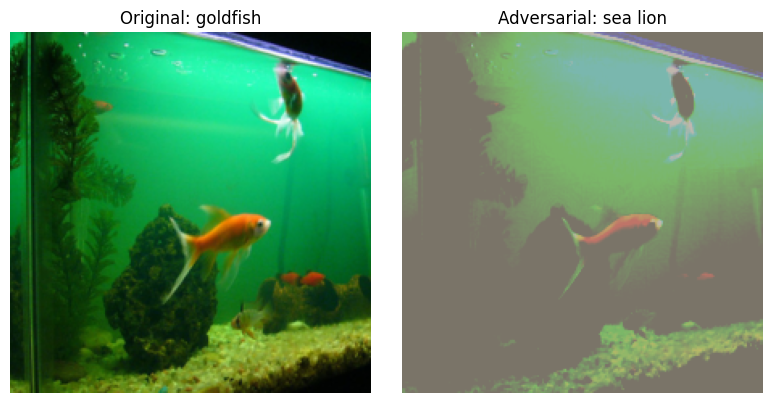

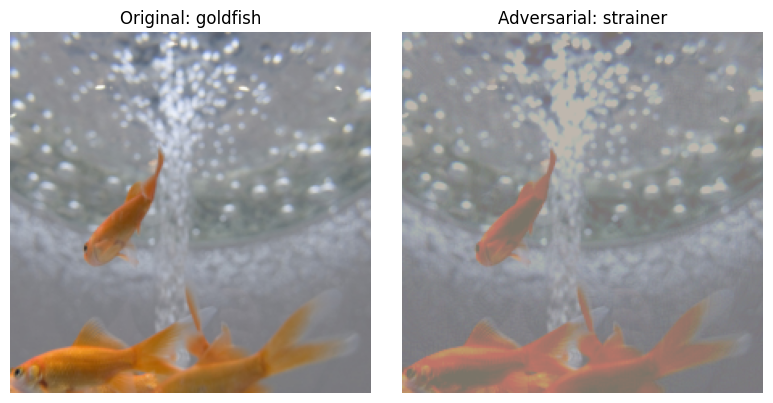

  0%|          | 2/782 [00:10<1:08:49,  5.29s/it]


KeyboardInterrupt: 

In [9]:
epsilon = 8 / 255  # 攻击强度
alpha = 2 / 255  # 每步扰动量
num_iterations = 10  # 攻击迭代次数

model.eval()  # 切换到评估模式
class_names = test_dataset.classnames  # 类别名称

for batch_idx, batch in enumerate(tqdm(test_loader, ascii=True)):
    images, labels = batch[0], batch[1]
    images, labels = images.to(device), labels.to(device)
    
    # 原始预测
    with torch.no_grad():
        original_logits = model(images)
        original_preds = torch.argmax(original_logits, dim=1)

    # 对抗样本生成
    adversarial_images = PGD(images, labels, model, eps=epsilon, alpha=alpha, steps=num_iterations)
    
    # 对抗样本预测
    with torch.no_grad():
        adversarial_logits = model(adversarial_images)
        adversarial_preds = torch.argmax(adversarial_logits, dim=1)

    # 可视化前2张图片
    visualize_images(
        original_images=images[:2],
        adversarial_images=adversarial_images[:2],
        labels=original_preds[:2],
        adv_labels=adversarial_preds[:2],
        class_names=class_names
    )
    
    if batch_idx == 10:
        break  # 仅显示十批数据
